In [ ]:
#Using miscnn framework 

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# Library import
from miscnn.data_loading.interfaces.nifti_io \
     import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO
interface = NIFTI_interface(pattern="00[0-9]*", 
                            channels=1, classes=3)

data_path = "../imagenes/mri/data/"
# Create the Data I/O object 
data_io = Data_IO(interface, data_path)

In [3]:
sample_list = data_io.get_indiceslist()
sample_list.sort()
print("All samples: " + str(sample_list))

All samples: ['case_00000', 'case_00001', 'case_00002', 'case_00003', 'case_00004', 'case_00005', 'case_00006', 'case_00007', 'case_00008', 'case_00009', 'case_00010', 'case_00011', 'case_00012', 'case_00013', 'case_00014', 'case_00015', 'case_00016', 'case_00017', 'case_00018', 'case_00019', 'case_00020', 'case_00021', 'case_00022', 'case_00023', 'case_00024', 'case_00025', 'case_00026', 'case_00027', 'case_00028', 'case_00029', 'case_00030', 'case_00031', 'case_00032', 'case_00033', 'case_00034', 'case_00035', 'case_00036', 'case_00037', 'case_00038', 'case_00039', 'case_00040', 'case_00041', 'case_00042', 'case_00043', 'case_00044', 'case_00045', 'case_00046', 'case_00047', 'case_00048', 'case_00049', 'case_00050', 'case_00051', 'case_00052', 'case_00053', 'case_00054', 'case_00055', 'case_00056', 'case_00057', 'case_00058', 'case_00059', 'case_00060', 'case_00061', 'case_00062', 'case_00063', 'case_00064', 'case_00065', 'case_00066', 'case_00067', 'case_00068', 'case_00069', 'case_

In [4]:
# Library import
from miscnn.processing.data_augmentation import Data_Augmentation

data_aug = Data_Augmentation(cycles=2, scaling=True, rotations=True, elastic_deform=True, mirror=True,
                             brightness=True, contrast=True, gamma=True, gaussian_noise=True)

In [5]:
# Library imports
from miscnn.processing.subfunctions.normalization import Normalization
from miscnn.processing.subfunctions.clipping import Clipping
from miscnn.processing.subfunctions.resampling import Resampling

# Create a pixel value normalization Subfunction through Z-Score 
sf_normalize = Normalization(z_score=True)
# Create a clipping Subfunction between -79 and 304
sf_clipping = Clipping(min=-79, max=304)
# Create a resampling Subfunction to voxel spacing 3.22 x 1.62 x 1.62
sf_resample = Resampling((3.22, 1.62, 1.62))

# Assemble Subfunction classes into a list
# Be aware that the Subfunctions will be exectued according to the list order!
subfunctions = [sf_resample, sf_clipping, sf_normalize]

In [6]:
# Library import
from miscnn.processing.preprocessor import Preprocessor

# Create and configure the Preprocessor class
pp = Preprocessor(data_io, data_aug=data_aug, batch_size=3, subfunctions=subfunctions, prepare_subfunctions=True, 
                  prepare_batches=False, analysis="patchwise-crop", patch_shape=(64, 128, 128))

# Adjust the patch overlap for predictions
pp.patchwise_overlap = (40, 80, 80)

Using TensorFlow backend.


In [7]:
# Library import
from miscnn.neural_network.model import Neural_Network
from miscnn.neural_network.metrics import dice_soft, dice_crossentropy, tversky_loss

from miscnn.neural_network.architecture.unet.standard import Architecture
unet_standard = Architecture(n_filters=3)

# Create the Neural Network model
model = Neural_Network(architecture=unet_standard, preprocessor=pp, loss=tversky_loss, metrics=[dice_soft, dice_crossentropy],
                       batch_queue_size=3, workers=3, learninig_rate=0.0001)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
from keras.callbacks import ReduceLROnPlateau
cb_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20, verbose=1, mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)
# Exclude suspious samples from data set
del sample_list[133]
del sample_list[125]
del sample_list[68]
del sample_list[37]
del sample_list[23]
del sample_list[15]

# Create the validation sample ID list
validation_samples = sample_list[0:120]

In [ ]:
# Library import
from miscnn.evaluation.cross_validation import cross_validation
# Run cross-validation function
cross_validation(validation_samples, model, k_fold=3, epochs=350, iterations=150,
                 evaluation_path="evaluation", draw_figures=True, callbacks=[cb_lr])

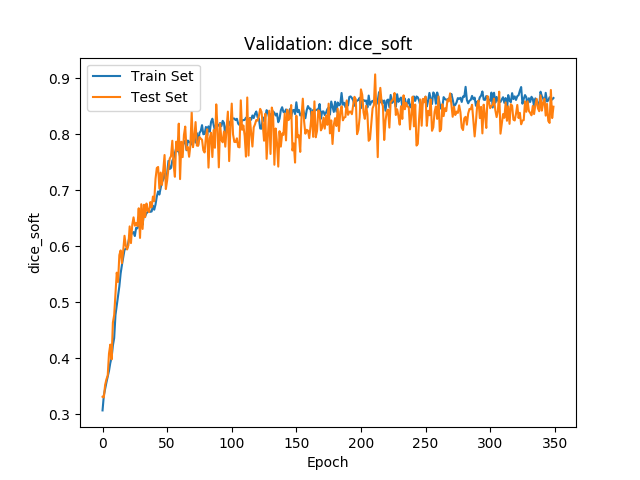

In [3]:
from IPython.display import Image
Image(filename = "evaluation/fold_0/validation.dice_soft.png")

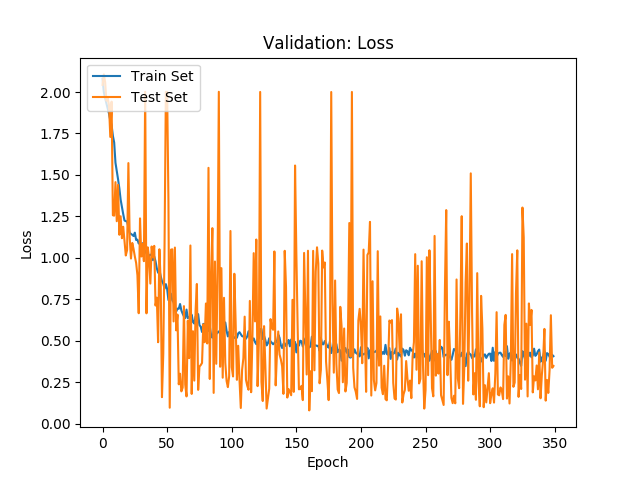

In [4]:
Image(filename = "evaluation/fold_0/validation.loss.png")

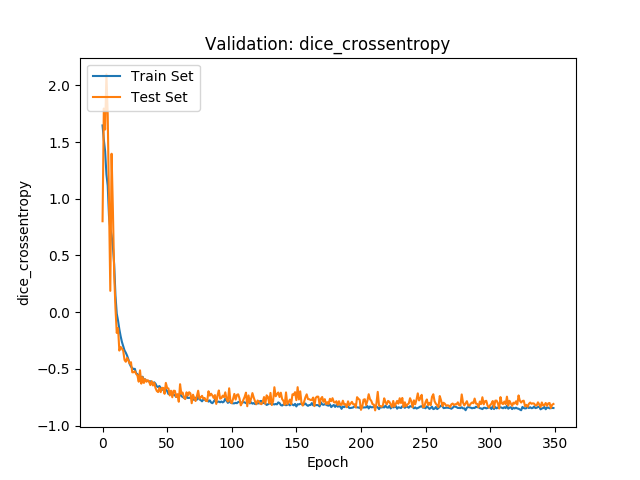

In [5]:
Image(filename = "evaluation/fold_0/validation.dice_crossentropy.png")

## Evaluation

In [16]:
import csv
kidney = []
tumor = []
start = True
with open("evaluation/fold_0/detailed_validation.tsv") as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    for line in tsvreader:
        print(line)
        if start:
            start = False
            continue
        kidney.append(float(line[2]))
        tumor.append(float(line[3]))

['sample_id', 'dice_class-0', 'dice_class-1', 'dice_class-2']
['case_00002', '0.9995979854078331', '0.9382278690280684', '0.7600283343452743']
['case_00051', '0.9995564092394915', '0.9378849954841159', '0.59603490354719']
['case_00035', '0.9998934500057399', '0.9665733311372032', '0.7851029377746935']
['case_00008', '0.999607278235371', '0.8837339488431809', '0.8806957519529541']
['case_00031', '0.9994944105207957', '0.9447786979864732', '0.12993932218440135']
['case_00038', '0.9993912076775896', '0.9585400477960543', '0.8247896627909572']
['case_00025', '0.9993124244137668', '0.9433228862711193', '0.9547118260950712']
['case_00027', '0.9998476022234882', '0.974504516551746', '0.4491084378466001']
['case_00107', '0.9993637913257692', '0.8689577912456158', '0.898406264248609']
['case_00109', '0.9992375145696671', '0.9288534153715242', '0.9134963836787918']
['case_00098', '0.9996684362393842', '0.9652812193698307', '0.8188398849472674']
['case_00016', '0.9997455124607473', '0.96429850308

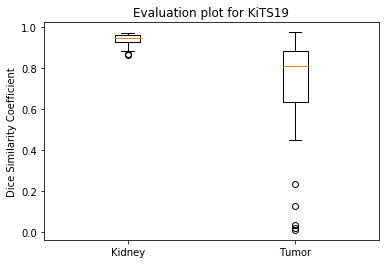

In [29]:
import matplotlib.pyplot as plt
import numpy as np

kidney = np.asarray(kidney) 
tumor = np.asarray(tumor) 

fig, ax = plt.subplots()
ax.set_title('Evaluation plot for KiTS19')
ax.set_ylabel('Dice Similarity Coefficient')
ax.set_xticklabels(["Kidney", "Tumor"])
ax.boxplot([kidney, tumor])
plt.show()